In [1]:
import json
import numpy as np
import pandas as pd
from inline_sql import sql 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Importación tablas

In [2]:
pozos = pd.read_csv("pozos-limpios.csv")
produccion = pd.read_csv("prod-no-nula.csv")
produccion = produccion[produccion['idpozo'].isin(pozos['idpozo'])]

len(produccion['idpozo'].unique()) == len(pozos['idpozo'].unique())

C:\Users\carri\AppData\Local\Temp\ipykernel_14224\1126773726.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  produccion = pd.read_csv("prod-no-nula.csv")


True

# F)

In [9]:
def pozo_outliers (df, id_pozo, plot, save):
    # Producciones de 2024 del pozo
    meses = df[df['idpozo'] == id_pozo][['idpozo', 'mes', 'prod_pet', 'prod_gas']]
    # Cuartiles Petroleo
    Q1 = np.percentile(meses['prod_pet'], 25)
    Q3 = np.percentile(meses['prod_pet'], 75)
    # Bigotes Petroleo
    bigote_sup = Q3 + 1.5*(Q3-Q1)
    bigote_inf = Q1 - 1.5*(Q3-Q1)
    # Anómalo Petroleo
    meses['anomalo_pet'] =  (meses['prod_pet'] < bigote_inf) | (meses['prod_pet'] > bigote_sup)

    if (plot):
        def formatter(x, pos):
            return f'{x:,.0f}'
            
        colores = ['red', 'yellow', 'green']
        condiciones = [(meses['prod_pet'] < bigote_inf) | (meses['prod_pet'] > bigote_sup),
                       (meses['prod_pet'] >= bigote_inf) & (meses['prod_pet'] <= bigote_sup) & ((meses['prod_pet'] < Q1) | (meses['prod_pet'] > Q3)),
                       (meses['prod_pet'] >= Q1) & (meses['prod_pet'] <= Q3)]
        colores = ['red', 'orange', 'green']
        meses['color'] = np.select(condiciones, colores, default='gray')
        
        fig, ax = plt.subplots(figsize=(7,4))

        ax.plot(meses['mes'], meses['prod_pet'], color='black', linewidth=0.7)
        ax.set_ylim(ymin=max(0,ax.get_ylim()[0]) , ymax=ax.get_ylim()[1])
        
        ax.axhline(y=bigote_sup, linestyle='--', color='red', linewidth=0.5)
        ax.axhspan(bigote_sup, ax.get_ylim()[1], color='red', alpha=0.1)
        
        ax.axhline(y=bigote_inf, linestyle='--', color='red', linewidth=0.5)
        ax.axhspan(ax.get_ylim()[0], bigote_inf, color='red', alpha=0.1)
        
        ax.axhline(y=Q1, linestyle='--', color='orange', linewidth=0.5)
        ax.axhspan(bigote_inf, Q1, color='orange', alpha=0.1)
        
        ax.axhline(y=Q3, linestyle='--', color='orange', linewidth=0.5)
        ax.axhspan(Q3, bigote_sup, color='orange', alpha=0.1)

        ax.axhspan(Q1, Q3, color='green', alpha=0.1)
        ax.grid(axis='x', linewidth=0.5, linestyle='--')

        ax.scatter(meses['mes'], meses['prod_pet'], c=meses['color'], alpha=1, s=50)
        ax.set(xticks=meses['mes'])
        ax.set_xlabel('Mes')
        ax.set_ylabel(f'Producción de petróleo (m3)\n (Pozo {id_pozo})')

        # Descarga imagen
        if (save):
            plt.savefig('pozo-anomalias-mes-pet.png', dpi=300, bbox_inches='tight')
    
    # Cuartiles Gas
    Q1 = np.percentile(meses['prod_gas'], 25)
    Q3 = np.percentile(meses['prod_gas'], 75)
    # Bigotes Gas
    bigote_sup = Q3 + 1.5*(Q3-Q1)
    bigote_inf = Q1 - 1.5*(Q3-Q1)
    # Anómalo Gas
    meses['anomalo_gas'] =  (meses['prod_gas'] < bigote_inf) | (meses['prod_gas'] > bigote_sup)
    
    if (plot):   
        colores = ['red', 'orange', 'green']
        condiciones = [(meses['prod_gas'] < bigote_inf) | (meses['prod_gas'] > bigote_sup),
                       (meses['prod_gas'] >= bigote_inf) & (meses['prod_gas'] <= bigote_sup) & ((meses['prod_gas'] < Q1) | (meses['prod_gas'] > Q3)),
                       (meses['prod_gas'] >= Q1) & (meses['prod_gas'] <= Q3)]
        meses['color'] = np.select(condiciones, colores, default='gray')
        
        fig, ax = plt.subplots(figsize=(7,4))
        
        ax.plot(meses['mes'], meses['prod_gas'], color='black', linewidth=0.7)
        ax.set_ylim(ymin=max(0,ax.get_ylim()[0]), ymax=ax.get_ylim()[1])
        
        ax.axhline(y=bigote_sup, linestyle='--', color='red', linewidth=0.5)
        ax.axhspan(bigote_sup, ax.get_ylim()[1], color='red', alpha=0.1)
        
        ax.axhline(y=bigote_inf, linestyle='--', color='red', linewidth=0.5)
        ax.axhspan(ax.get_ylim()[0], bigote_inf, color='red', alpha=0.1)
        
        ax.axhline(y=Q1, linestyle='--', color='orange', linewidth=0.5)
        ax.axhspan(bigote_inf, Q1, color='orange', alpha=0.1)
        
        ax.axhline(y=Q3, linestyle='--', color='orange', linewidth=0.5)
        ax.axhspan(Q3, bigote_sup, color='orange', alpha=0.1)

        ax.axhspan(Q1, Q3, color='green', alpha=0.1)
        ax.grid(axis='x', linewidth=0.5, linestyle='--')
        
        ax.scatter(meses['mes'], meses['prod_gas'], c=meses['color'], alpha=1, s=50)
        ax.set(xticks=meses['mes'])
        ax.set_xlabel('Mes')
        ax.set_ylabel(f'Producción de gas (mm3)\n (Pozo {id_pozo})')

        # Descarga imagen
        if (save):
            plt.savefig('pozo-anomalias-mes-gas.png', dpi=300, bbox_inches='tight')
            
        
    return meses[['mes', 'anomalo_pet', 'anomalo_gas']]
    

,mes,anomalo_pet,anomalo_gas
94,1,False,False
24833,2,False,False
36216,3,False,False
50201,4,False,False
62429,5,False,False
74495,6,True,False
87011,7,True,False
99790,8,False,False
112828,9,False,False
127855,10,False,False


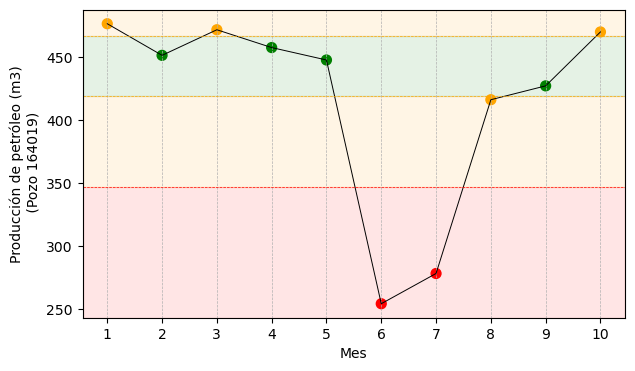

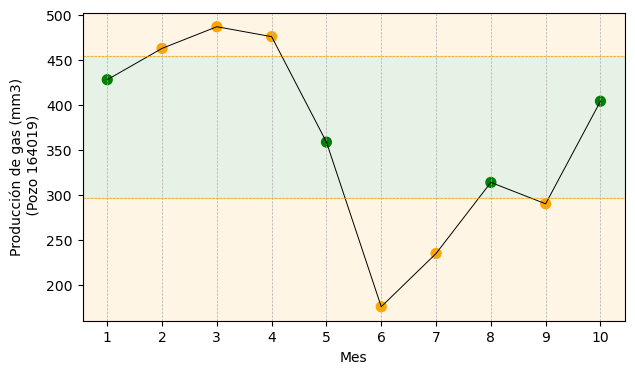

In [11]:
pozo_outliers(produccion, 164019, True, True)

In [5]:
def outliers (produccion):
    outliers_pet = {}
    outliers_gas = {}
    for Id in produccion['idpozo'].unique():
        idpozo = int(Id)
        # Outliers del pozo
        outliers = pozo_outliers(produccion, idpozo, False, False)
        # Outliers de petroleo
        if (outliers['anomalo_pet'].any()):
            meses_outliers = outliers[outliers['anomalo_pet'] == True] ['mes']
            outliers_pet[idpozo] = meses_outliers.to_list()
            
        # Outliers de gas   
        if (outliers['anomalo_gas'].any()):
            meses_outliers = outliers[outliers['anomalo_gas'] == True] ['mes']
            outliers_gas[idpozo] = meses_outliers.to_list()
        
    return outliers_pet, outliers_gas

In [6]:
outliers_pet, outliers_gas = outliers(produccion)

In [7]:
len(outliers_pet)

9813

In [8]:
len(outliers_gas)

9260

In [9]:
meses_outliers_pet = 0
meses_outliers_gas = 0

for key in outliers_pet.keys():
    meses_outliers_pet += len(outliers_pet[key])

for key in outliers_gas.keys():
    meses_outliers_gas += len(outliers_gas[key])

meses_outliers_pet, meses_outliers_gas

(14720, 13667)

# G)

## Comparación 2023

In [3]:
prod_provincias_pet = pd.read_csv("produccin-de-petrleo-promedio-diaria-por-provincia.csv")
prod_provincias_gas = pd.read_csv("produccin-de-gas-promedio-diaria-por-provincia.csv")
produccion23 = pd.read_csv("produccin-de-pozos-de-gas-y-petrleo-2023.csv")

C:\Users\carri\AppData\Local\Temp\ipykernel_14224\3736125882.py:3: DtypeWarning: Columns (16,36) have mixed types. Specify dtype option on import or set low_memory=False.
  produccion23 = pd.read_csv("produccin-de-pozos-de-gas-y-petrleo-2023.csv")


In [4]:
def compare_2023 (df24, df23, id_pozo, plot, save):
    
    # Producciones de 2023 y 2024 del pozo
    prods24 = df24[df24['idpozo'] == id_pozo][['mes', 'prod_pet', 'prod_gas']].sort_values(by='mes').reset_index(drop=True)
    prods23 = df23[df23['idpozo'] == id_pozo][['mes', 'prod_pet', 'prod_gas']].sort_values(by='mes').reset_index(drop=True)
    
    # Inicio columnas
    prods24['anomalo_pet'] = False
    prods24['anomalo_gas'] = False
    
    # Me quedo con los meses comunes
    prods23 = prods23[prods23['mes'].isin(prods24['mes'])].reset_index(drop=True)
    prods24 = prods24[prods24['mes'].isin(prods23['mes'])].reset_index(drop=True)
    
    if not (prods24.empty):
        # Diferencias en produccion de petroleo entre años
        prods24['diferences_pet'] = abs(prods24['prod_pet'].values-prods23['prod_pet'].values)
        
        # Busco valores muy altos
        Q1 = np.percentile(prods24['diferences_pet'], 25)
        Q3 = np.percentile(prods24['diferences_pet'], 75)
        bigote_sup = Q3 + 1*(Q3-Q1)
        bigote_inf = Q1 - 1*(Q3-Q1)
        
        # Filtro outliers
        prods24['anomalo_pet'] = (prods24['diferences_pet'] > bigote_sup) | (prods24['diferences_pet'] < bigote_inf)
        
        # Ploteo
        if (plot):
            colores = ['red', 'orange', 'green']
            condiciones = [(prods24['diferences_pet'] < bigote_inf) | (prods24['diferences_pet'] > bigote_sup),
                           (prods24['diferences_pet'] >= bigote_inf) & (prods24['diferences_pet'] <= bigote_sup) 
                           & ((prods24['diferences_pet'] < Q1) | (prods24['diferences_pet'] > Q3)),
                           (prods24['diferences_pet'] >= Q1) & (prods24['diferences_pet'] <= Q3)]
            prods24['color'] = np.select(condiciones, colores, default='gray')
            
            fig, ax = plt.subplots(figsize=(7,4))
            maxs = []
            mins = []
            for i in range (len(prods24['prod_pet'])):
                maxs.append(max(prods24['prod_pet'][i], prods23['prod_pet'][i]))
                mins.append(min(prods24['prod_pet'][i], prods23['prod_pet'][i]))
            
            ax.vlines(x=prods24['mes'], ymin=mins, ymax=maxs, colors=prods24['color'], linewidth=2)
            ax.scatter(prods24['mes'], prods24['prod_pet'], color='black', alpha=1, s=100, label='2024')
            ax.scatter(prods24['mes'], prods23['prod_pet'], color='black', alpha=0.5, s=100, label='2023')
    
            ax.grid(axis='y', linewidth=0.5, linestyle='--')
            ax.legend()
            ax.set(xticks=prods24['mes'])
            ax.set_xlabel('Mes')
            ax.set_ylabel(f'Producción de petróleo (m3)\n (Pozo {id_pozo})')

            if (save):
                plt.savefig('pozo-anomalias-2023-pet.png', dpi=300, bbox_inches='tight')
            
        # Diferencias en produccion de gas entre años
        prods24['diferences_gas'] = abs(prods24['prod_gas'].values-prods23['prod_gas'].values)
        
        # Busco valores muy altos
        Q1 = np.percentile(prods24['diferences_gas'], 25)
        Q3 = np.percentile(prods24['diferences_gas'], 75)
        bigote_sup = Q3 + 1*(Q3-Q1)
        bigote_inf = Q1 - 1*(Q3-Q1)
        
        # Filtro outliers
        prods24['anomalo_gas'] = (prods24['diferences_gas'] > bigote_sup) | (prods24['diferences_gas'] < bigote_inf)
        
        # Ploteo
        if (plot):
            colores = ['red', 'orange', 'green']
            condiciones = [(prods24['diferences_gas'] < bigote_inf) | (prods24['diferences_gas'] > bigote_sup),
                           (prods24['diferences_gas'] >= bigote_inf) & (prods24['diferences_gas'] <= bigote_sup) 
                           & ((prods24['diferences_gas'] < Q1) | (prods24['diferences_gas'] > Q3)),
                           (prods24['diferences_gas'] >= Q1) & (prods24['diferences_gas'] <= Q3)]
            prods24['color'] = np.select(condiciones, colores, default='gray')
            
            fig, ax = plt.subplots(figsize=(7,4))
            maxs = []
            mins = []
            for i in range (len(prods24['prod_gas'])):
                maxs.append(max(prods24['prod_gas'][i], prods23['prod_gas'][i]))
                mins.append(min(prods24['prod_gas'][i], prods23['prod_gas'][i]))
            
            ax.vlines(x=prods24['mes'], ymin=mins, ymax=maxs, colors=prods24['color'], linewidth=2)
            ax.scatter(prods24['mes'], prods24['prod_gas'], color='black', alpha=1, s=100, label='2024')
            ax.scatter(prods24['mes'], prods23['prod_gas'], color='black', alpha=0.5, s=100, label='2023')
    
            ax.grid(axis='y', linewidth=0.5, linestyle='--')
            ax.legend()
            ax.set(xticks=prods24['mes'])
            ax.set_xlabel('Mes')
            ax.set_ylabel(f'Producción de gas (mm3)\n (Pozo {id_pozo})')

            if (save):
                plt.savefig('pozo-anomalias-2023-gas.png', dpi=300, bbox_inches='tight')

    return prods24[['mes', 'anomalo_pet', 'anomalo_gas']]

,mes,anomalo_pet,anomalo_gas
0,1,False,False
1,2,False,False
2,3,False,False
3,4,False,False
4,5,False,True
5,6,False,False
6,7,True,False
7,8,True,False
8,9,False,False
9,10,False,False


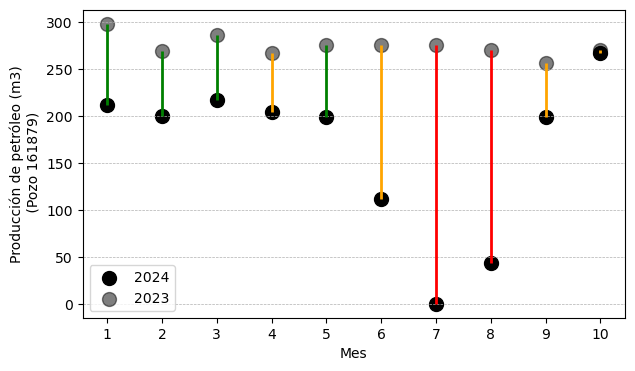

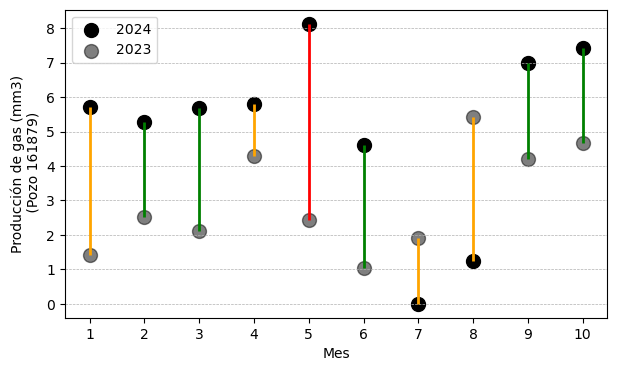

In [12]:
compare_2023(produccion, produccion23, 161879, True, True)

In [13]:
def outliers_comp23 (produccion, produccion23):
    outliers_pet = {}
    outliers_gas = {}
    for Id in produccion['idpozo'].unique():
        idpozo = int(Id)
        
        # Outliers del pozo
        outliers = compare_2023(produccion, produccion23, idpozo, False, False)
        
        # Checkeo dataframe no vacío
        if not (outliers.empty):
            
            # Outliers de petroleo
            if (outliers['anomalo_pet'].any()):
                meses_outliers = outliers[outliers['anomalo_pet'] == True] ['mes']
                outliers_pet[idpozo] = meses_outliers.to_list()
                
            # Outliers de gas   
            if (outliers['anomalo_gas'].any()):
                meses_outliers = outliers[outliers['anomalo_gas'] == True] ['mes']
                outliers_gas[idpozo] = meses_outliers.to_list()
        
    return outliers_pet, outliers_gas

In [ ]:
outliers_comp23_pet, outliers_comp23_gas = outliers_comp23(produccion, produccion23)

In [ ]:
len(outliers_comp23_pet)

In [ ]:
len(outliers_comp23_gas)

In [ ]:
meses_outliers_comp23_pet = 0
meses_outliers_comp23_gas = 0

for key in outliers_comp23_pet.keys():
    meses_outliers_comp23_pet += len(outliers_comp23_pet[key])

for key in outliers_comp23_gas.keys():
    meses_outliers_comp23_gas += len(outliers_comp23_gas[key])

meses_outliers_comp23_pet, meses_outliers_comp23_gas

## Produccion por provincia

In [13]:
import calendar

In [14]:
prod_provincias_pet.info(), prod_provincias_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   anio                                 2256 non-null   int64  
 1   mes                                  2256 non-null   int64  
 2   indice_tiempo                        2256 non-null   object 
 3   provincia                            2256 non-null   object 
 4   produccion_petroleo_promedio_dia_m3  2256 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 88.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2301 entries, 0 to 2300
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   anio                             2301 non-null   int64  
 1   mes                              2301 non-null   int64  
 2   indice_tie

(None, None)

In [15]:
def produccion_provincias (produccion):
    prod_provincias = sql^ """
                           SELECT provincia, mes, SUM(prod_pet) AS prod_pet, SUM(prod_pet) AS prod_gas
                           FROM produccion
                           GROUP BY provincia, mes
                           ORDER BY provincia, mes
                           """
    
    for index in prod_provincias.index:
        mes = prod_provincias.loc[index, 'mes']
        prod_provincias.loc[index, 'prod_pet'] = prod_provincias.loc[index, 'prod_pet']/calendar.monthrange(2024, mes)[1]
        prod_provincias.loc[index, 'prod_gas'] = prod_provincias.loc[index, 'prod_gas']/calendar.monthrange(2024, mes)[1]

    prod_provincias.columns=['provincia', 'mes', 'prom_prod_pet_diaria', 'prom_prod_gas_diaria']
    return prod_provincias

In [16]:
prods_provincias =  produccion_provincias(produccion)

In [17]:
prods_provincias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   provincia             110 non-null    object 
 1   mes                   110 non-null    int64  
 2   prom_prod_pet_diaria  110 non-null    float64
 3   prom_prod_gas_diaria  110 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.6+ KB


In [18]:
def compare_provincia (prods_provincias, prods_provincias_pet, prods_provincias_gas, provincia, plot, save):
    
    # Miramos años anteriores
    provincias_no24_pet = prods_provincias_pet[prods_provincias_pet['anio'] != 2024]
    provincias_no24_gas = prods_provincias_gas[prods_provincias_gas['anio'] != 2024]
    
    # Comparamos la provincia
    prods_provincia = prods_provincias[prods_provincias['provincia'] == provincia].copy().reset_index(drop=True)
    provincia_no24_pet = provincias_no24_pet[provincias_no24_pet['provincia'] == provincia]
    provincia_no24_gas = provincias_no24_gas[provincias_no24_gas['provincia'] == provincia]
    
    # Hacemos promedios
    promedios = pd.DataFrame(columns=['mes', 'promedio_pet', 'promedio_gas'])
    for mes in sorted(provincia_no24_pet['mes'].unique()):
        promedios.loc[promedios.shape[0], 'mes'] = mes
        
        # Promedio petroleo
        prom_pet = np.mean(provincia_no24_pet[provincia_no24_pet['mes'] == mes]['produccion_petroleo_promedio_dia_m3'])
        promedios.loc[promedios.shape[0]-1, 'promedio_pet'] = prom_pet

        # Promedio gas
        prom_gas = np.mean(provincia_no24_gas[provincia_no24_gas['mes'] == mes]['produccion_gas_promedio_dia_mm3'])
        promedios.loc[promedios.shape[0]-1, 'promedio_gas'] = prom_gas
    
    # Inicio columnas
    prods_provincia.loc[prods_provincia.index, 'anomalo_pet'] = False
    prods_provincia.loc[prods_provincia.index, 'anomalo_gas'] = False

    # Filtramos los meses en común
    prods_provincia = prods_provincia[prods_provincia['mes'].isin(promedios['mes'])].reset_index(drop=True)
    promedios = promedios[promedios['mes'].isin(prods_provincia['mes'])].reset_index(drop=True)

    # Si el DataFrame no es vacío
    if not (prods_provincia.empty):
        
        # Diferencias en produccion de petroleo entre años
        prods_provincia['diferences_pet'] = abs(prods_provincia['prom_prod_pet_diaria'].values-promedios['promedio_pet'].values)
        
        # Busco valores anormales
        Q1 = np.percentile(prods_provincia['diferences_pet'], 25)
        Q3 = np.percentile(prods_provincia['diferences_pet'], 75)
        bigote_sup = Q3 + 1*(Q3-Q1)
        bigote_inf = Q1 - 1*(Q3-Q1)
        
        # Filtro outliers
        prods_provincia['anomalo_pet'] = (prods_provincia['diferences_pet'] > bigote_sup) | (prods_provincia['diferences_pet'] < bigote_inf)
        
        # Ploteo
        if (plot):

            # Coloreo
            colores = ['red', 'orange', 'green']
            condiciones = [(prods_provincia['diferences_pet'] < bigote_inf) | (prods_provincia['diferences_pet'] > bigote_sup),
                           (prods_provincia['diferences_pet'] >= bigote_inf) & (prods_provincia['diferences_pet'] <= bigote_sup) 
                           & ((prods_provincia['diferences_pet'] < Q1) | (prods_provincia['diferences_pet'] > Q3)),
                           (prods_provincia['diferences_pet'] >= Q1) & (prods_provincia['diferences_pet'] <= Q3)]
            prods_provincia['color'] = np.select(condiciones, colores, default='gray')

            # Genero gráfico
            fig, ax = plt.subplots(figsize=(8,4))

            # Minimos y maximos para lineas verticales
            maxs = []
            mins = []
            for i in range (len(prods_provincia['prom_prod_pet_diaria'])):
                maxs.append(max(prods_provincia['prom_prod_pet_diaria'][i], promedios['promedio_pet'][i]))
                mins.append(min(prods_provincia['prom_prod_pet_diaria'][i], promedios['promedio_pet'][i]))

            # Dibujo puntos y lineas
            ax.vlines(x=prods_provincia['mes'], ymin=mins, ymax=maxs, colors=prods_provincia['color'], linewidth=2)
            ax.scatter(prods_provincia['mes'], prods_provincia['prom_prod_pet_diaria'], color='black', alpha=1, s=100, label='2024')
            ax.scatter(promedios['mes'], promedios['promedio_pet'], color='black', alpha=0.5, s=100, label='Promedio mensual')

            # Personalizo grafico
            ax.grid(axis='y', linewidth=0.5, linestyle='--')
            ax.legend()
            ax.set(xticks=prods_provincia['mes'])
            ax.set_xlabel('Mes')
            ax.set_ylabel(f'Producción diaria de petróleo promedio (m3)\n ({provincia})')

            if (save):
                plt.savefig('provincia-anomalias-pet.png', dpi=300, bbox_inches='tight')

        # Diferencias en produccion de petroleo entre años
        prods_provincia['diferences_gas'] = abs(prods_provincia['prom_prod_gas_diaria'].values-promedios['promedio_gas'].values)
        
        # Busco valores muy altos
        Q1 = np.percentile(prods_provincia['diferences_gas'], 25)
        Q3 = np.percentile(prods_provincia['diferences_gas'], 75)
        bigote_sup = Q3 + 1*(Q3-Q1)
        bigote_inf = Q1 - 1*(Q3-Q1)
        
        # Filtro outliers
        prods_provincia['anomalo_gas'] = (prods_provincia['diferences_gas'] > bigote_sup) | (prods_provincia['diferences_gas'] < bigote_inf)
        
        # Plot
        if (plot):
            
            # Coloreo
            colores = ['red', 'orange', 'green']
            condiciones = [(prods_provincia['diferences_gas'] < bigote_inf) | (prods_provincia['diferences_gas'] > bigote_sup),
                           (prods_provincia['diferences_gas'] >= bigote_inf) & (prods_provincia['diferences_gas'] <= bigote_sup) 
                           & ((prods_provincia['diferences_gas'] < Q1) | (prods_provincia['diferences_gas'] > Q3)),
                           (prods_provincia['diferences_gas'] >= Q1) & (prods_provincia['diferences_gas'] <= Q3)]
            prods_provincia['color'] = np.select(condiciones, colores, default='gray')

            # Genero gráfico
            fig, ax = plt.subplots(figsize=(8,4))

            # Minimos y maximos para lineas verticales
            maxs = []
            mins = []
            for i in range (len(prods_provincia['prom_prod_gas_diaria'])):
                maxs.append(max(prods_provincia['prom_prod_gas_diaria'][i], promedios['promedio_gas'][i]))
                mins.append(min(prods_provincia['prom_prod_gas_diaria'][i], promedios['promedio_gas'][i]))

            # Dibujo puntos y lineas
            ax.vlines(x=prods_provincia['mes'], ymin=mins, ymax=maxs, colors=prods_provincia['color'], linewidth=2)
            ax.scatter(prods_provincia['mes'], prods_provincia['prom_prod_gas_diaria'], color='black', alpha=1, s=100, label='2024')
            ax.scatter(promedios['mes'], promedios['promedio_gas'], color='black', alpha=0.5, s=100, label='Promedio mensual')

            # Personalizo grafico
            ax.grid(axis='y', linewidth=0.5, linestyle='--')
            ax.legend()
            ax.set(xticks=prods_provincia['mes'])
            ax.set_xlabel('Mes')
            ax.set_ylabel(f'Producción diaria de gas promedio (mm3)\n ({provincia})')

            if (save):
                plt.savefig('provincia-anomalias-gas.png', dpi=300, bbox_inches='tight')

    return prods_provincia[['mes', 'anomalo_pet', 'anomalo_gas']]
    

,mes,anomalo_pet,anomalo_gas
0,1,False,False
1,2,False,False
2,3,False,False
3,4,False,False
4,5,False,False
5,6,True,True
6,7,True,True
7,8,False,False
8,9,False,False
9,10,False,False


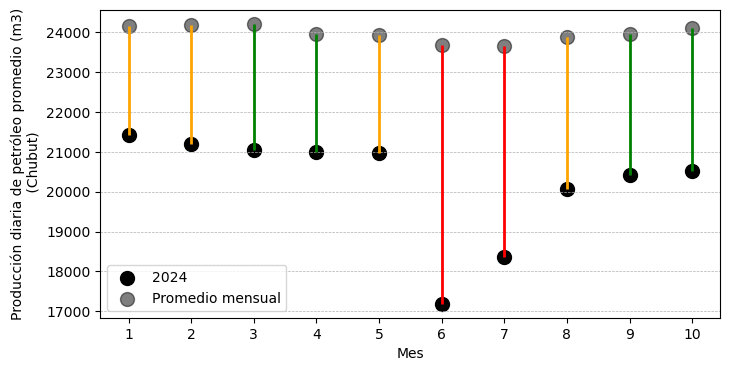

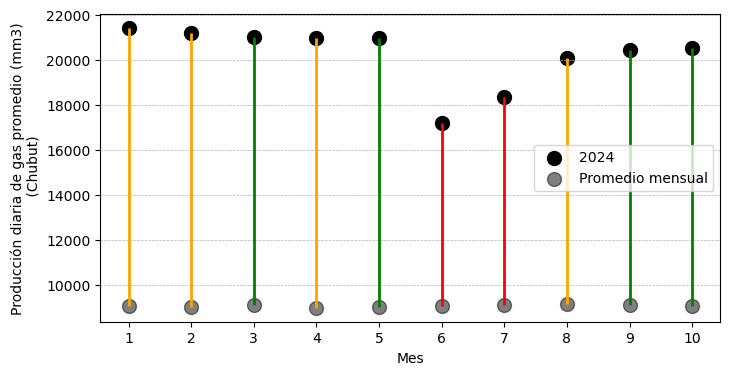

In [21]:
compare_provincia(prods_provincias, prod_provincias_pet, prod_provincias_gas, 'Chubut', True, True)

In [ ]:
def outliers_provincias (prods_provincias, prods_provincias_pet, prods_provincias_gas):
    outliers_pet = {}
    outliers_gas = {}
    provincias = prods_provincias['provincia'].unique()
    for provincia in provincias:
        
        # Outliers del pozo
        outliers = compare_provincia(prods_provincias, prods_provincias_pet, prods_provincias_gas, provincia, False)
        
        # Checkeo dataframe no vacío
        if not (outliers.empty):
            
            # Outliers de petroleo
            if (outliers['anomalo_pet'].any()):
                meses_outliers = outliers[outliers['anomalo_pet'] == True]['mes']
                outliers_pet[provincia] = meses_outliers.to_list()
                
            # Outliers de gas   
            if (outliers['anomalo_gas'].any()):
                meses_outliers = outliers[outliers['anomalo_gas'] == True]['mes']
                outliers_gas[provincia] = meses_outliers.to_list()
        
    return outliers_pet, outliers_gas

In [ ]:
outliers_provincias_pet, outliers_provincias_gas = outliers_provincias(prods_provincias, prod_provincias_pet, prod_provincias_gas)

In [ ]:
outliers_provincias_pet

In [ ]:
outliers_provincias_gas

In [ ]:
meses_outliers_provincias_pet = 0
meses_outliers_provincias_gas = 0

for key in outliers_provincias_pet.keys():
    meses_outliers_provincias_pet += len(outliers_provincias_pet[key])

for key in outliers_provincias_gas.keys():
    meses_outliers_provincias_gas += len(outliers_provincias_gas[key])

meses_outliers_provincias_pet, meses_outliers_provincias_gas

In [ ]:
def outliers_petroleo (pozos, outliers, outliers_comp23, outliers_provincias):
    idpozos = pd.Series((list(outliers.keys()) + list(outliers_comp23.keys()))).unique()
    pozos_outliers = {}
    for pozoid in idpozos:
        
        # Informacion pozo
        provincia = pozos[pozos['idpozo'] == pozoid]['provincia'].iloc[0]
        meses = []
        
        # Meses outliers 
        if pozoid in outliers.keys():
            meses += outliers[pozoid]
            
        # Meses outliers (comparado 2023)
        if pozoid in outliers_comp23.keys():
            meses += outliers_comp23[pozoid]

        # Verifico que no se deba a una anomalia general
        if (len(meses) > 0):
            for mes in meses:
                if provincia in outliers_provincias.keys():
                    if not (mes in outliers_provincias[provincia]):
                        meses.append(mes)

        pozos_outliers[pozoid] = meses

    return pozos_outliers

In [ ]:
pozos_outliers_pet = outliers_petroleo(pozos, outliers_pet, outliers_comp23_pet, outliers_provincias_pet)

In [ ]:
len(pozos_outliers_pet)